# Assignment 4: CNN implementation (ResNet-50)

This notebook implements a ResNet-50 model for CIFAR-10 with the required training settings.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)

# Flatten labels to 1D
y_train = y_train.squeeze()
y_test = y_test.squeeze()

# Combine so we can split 70/30 as requested
x_combined = np.concatenate([x_train, x_test], axis=0)
y_combined = np.concatenate([y_train, y_test], axis=0)

# Normalize
x_combined = x_combined.astype("float32") / 255.0

# 70/30 split
x_train, x_test, y_train, y_test = train_test_split(
    x_combined, y_combined, test_size=0.30, random_state=7, stratify=y_combined
)

# Something to note is that I never resized the images, so they are still 32x32.
# This is with the class example uses 96x96.
x_train.shape, x_test.shape, y_train.shape, y_test.shape

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 19s 0us/step


((42000, 32, 32, 3), (18000, 32, 32, 3), (42000,), (18000,))

## Task number one: Implement ResNet-50 for CIFAR-10

Architecture follows the original ResNet-50 bottleneck pattern. I had a picture added below but it don't think it would load without me submitting an HTML

In [3]:
def bottleneck_block(x, filters, stride=1, projection=False):
    shortcut = x

    # 1x1 reduce
    x = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 3x3
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 1x1 expand
    x = layers.Conv2D(filters * 4, kernel_size=1, strides=1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    if projection:
        shortcut = layers.Conv2D(filters * 4, kernel_size=1, strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x


def build_resnet50(dropout_rate=0.5):
    # Input layer of shape (32, 32, 3) for CIFAR-10
    inputs = keras.Input(shape=(32, 32, 3))

    # Start coming from the original ResNet paper
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # conv2_x has 3 blocks
    x = bottleneck_block(x, filters=64, stride=1, projection=True)
    x = bottleneck_block(x, filters=64)
    x = bottleneck_block(x, filters=64)

    # conv3_x has 4 blocks
    x = bottleneck_block(x, filters=128, stride=2, projection=True)
    x = bottleneck_block(x, filters=128)
    x = bottleneck_block(x, filters=128)
    x = bottleneck_block(x, filters=128)

    # conv4_x has 6 blocks
    x = bottleneck_block(x, filters=256, stride=2, projection=True)
    x = bottleneck_block(x, filters=256)
    x = bottleneck_block(x, filters=256)
    x = bottleneck_block(x, filters=256)
    x = bottleneck_block(x, filters=256)
    x = bottleneck_block(x, filters=256)

    # conv5_x has 3 blocks
    x = bottleneck_block(x, filters=512, stride=2, projection=True)
    x = bottleneck_block(x, filters=512)
    x = bottleneck_block(x, filters=512)

    # Global average pooling and output layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(10, activation='softmax')(x)

    return keras.Model(inputs, outputs, name='ResNet50')

In [4]:
model = build_resnet50(dropout_rate=0.5)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "ResNet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 8, 8, 64)  │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │      4,096 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,864 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 256) │     16,384 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 256) │     16,384 │ max_pooling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 256) │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 256) │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 8, 8, 256) │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 8, 8, 64)  │     16,384 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 23,581,642 (89.96 MB)

 Trainable params: 23,528,522 (89.75 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [5]:
# Train
history = model.fit(
    x_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(x_test, y_test),
    verbose=2
)

Epoch 1/50
1313/1313 - 103s - 78ms/step - accuracy: 0.1984 - loss: 3.0769 - val_accuracy: 0.3203 - val_loss: 2.5546
Epoch 2/50
1313/1313 - 35s - 27ms/step - accuracy: 0.3174 - loss: 2.2168 - val_accuracy: 0.3704 - val_loss: 2.4509
Epoch 3/50
1313/1313 - 35s - 27ms/step - accuracy: 0.3802 - loss: 1.9550 - val_accuracy: 0.4097 - val_loss: 2.8482
Epoch 4/50
1313/1313 - 37s - 28ms/step - accuracy: 0.4148 - loss: 1.8226 - val_accuracy: 0.3857 - val_loss: 1.7303
Epoch 5/50
1313/1313 - 39s - 30ms/step - accuracy: 0.4256 - loss: 1.7560 - val_accuracy: 0.4087 - val_loss: 1.6067
Epoch 6/50
1313/1313 - 35s - 27ms/step - accuracy: 0.4415 - loss: 1.7109 - val_accuracy: 0.4779 - val_loss: 1.4391
Epoch 7/50
1313/1313 - 35s - 27ms/step - accuracy: 0.4607 - loss: 1.6260 - val_accuracy: 0.3904 - val_loss: 1.8484
Epoch 8/50
1313/1313 - 36s - 27ms/step - accuracy: 0.4808 - loss: 1.5501 - val_accuracy: 0.4841 - val_loss: 1.6024
Epoch 9/50
1313/1313 - 35s - 27ms/step - accuracy: 0.5169 - loss: 1.4650 - val_

In [6]:
# Evaluate training and testing accuracy
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)

print(f'Training accuracy: {train_acc:.4f}')
print(f'Testing accuracy:  {test_acc:.4f}')

Training accuracy: 0.9794
Testing accuracy:  0.6791


We see that the model does really well on the training but performs poor on the testing dataset. This likely means we have overfitting which makes sense, because this is a pretty intense model for only 32x32 images. Where the original paper trained on images of 224x224

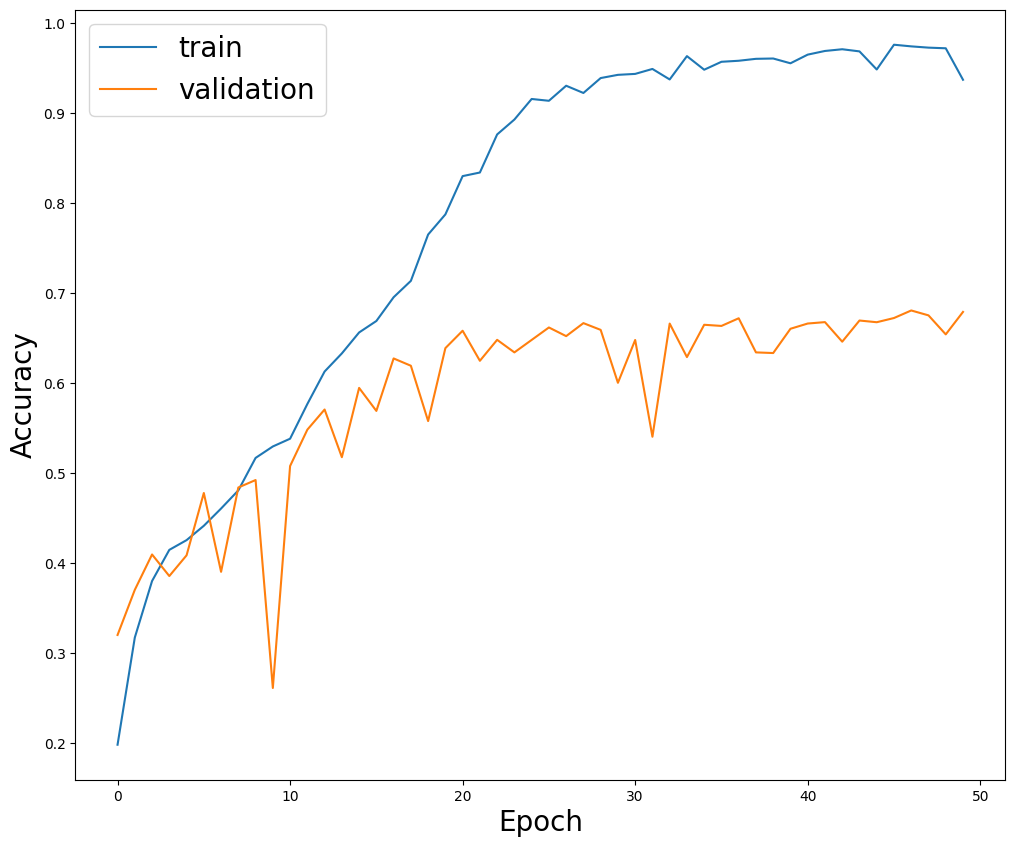

In [9]:
import pandas as pd

# Visualize training history
def plot_history(hist):
    plt.figure(figsize=(12, 10))
    plt.xlabel('Epoch',fontsize=20)
    plt.ylabel('Accuracy',fontsize=20)
    plt.plot(hist['epoch'], hist['accuracy'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'], label = 'Val Error')
    plt.legend(["train", "validation"], loc="upper left", prop={'size': 20})

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plot_history(hist)

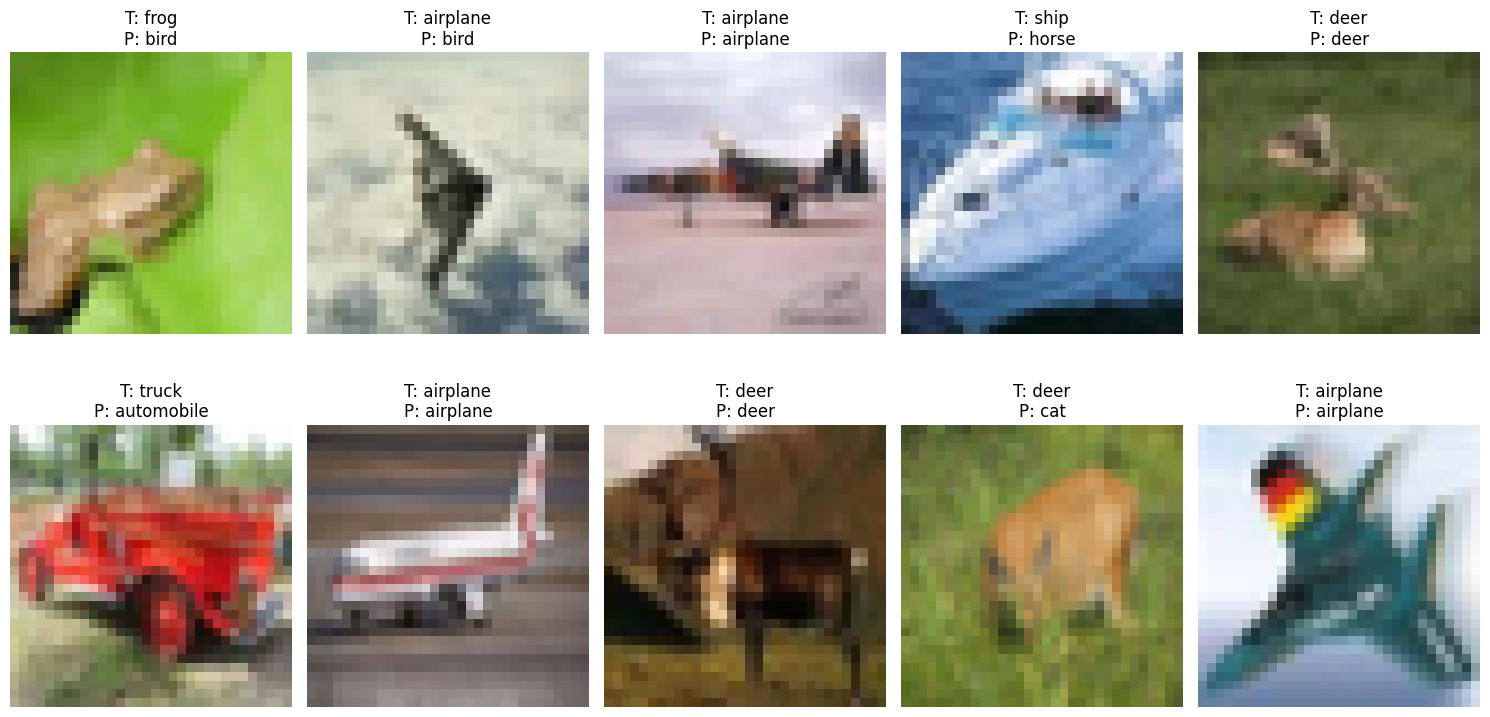

In [10]:
# Predict the last 10 images from the test set
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Last 10 samples
images = x_test[-10:]
labels = y_test[-10:]

fig, ax = plt.subplots(2, 5, figsize=(15, 8))
ax = ax.flatten()

for i in range(10):
    img = images[i]
    true_label = labels[i]

    # predict one image
    pred = model.predict(img[None, ...], verbose=0).argmax()

    ax[i].imshow(img)
    ax[i].set_title(
        f"T: {CLASS_NAMES[true_label]}\nP: {CLASS_NAMES[pred]}",
        fontsize=12
    )
    ax[i].axis("off")

plt.tight_layout()
plt.show()